In [119]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from src.util_evaluation_scores import get_scores

import lightgbm as lgb
import numpy as np
import pandas as pd
import pickle

from src.preprocessing_data import DataPreprocessing
from src.util_training_evaluation import TrainingEvaluation

import warnings
warnings.filterwarnings('ignore')

### Pre-processing Training Data

In [4]:
data_preprocessor = DataPreprocessing(data_job_desc_path = "data/job_desc.csv",
                                      data_user_path = "data/user.csv")
train_data = data_preprocessor.handler()
train_data.head()

,has_applied,salary,v1,v10,v11,v12,v13,v14,v15,v16,...,jobtitle_keyword_senior,jobtitle_keyword_seo,jobtitle_keyword_shop,jobtitle_keyword_software,jobtitle_keyword_supplier,jobtitle_keyword_sustainability,jobtitle_keyword_transformation,jobtitle_keyword_ui,jobtitle_keyword_ux,jobtitle_keyword_ventures
0,1,51000.0,0.620573,0.018662,0.100803,0.080898,0.420417,0.817681,0.147355,0.446812,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,70000.0,0.972502,0.870277,0.504887,0.995163,0.179480,0.608719,0.245085,0.851246,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,59000.0,0.240756,0.546440,0.521399,0.402420,0.640444,0.400145,0.184515,0.395058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,58200.0,0.004854,0.433188,0.250801,0.242680,0.713586,0.210186,0.977472,0.375024,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,64000.0,0.835250,0.476812,0.764354,0.449753,0.524924,0.807181,0.294023,0.475043,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Training Models: Classical ML Algos

In [13]:
lr_model_ini = LogisticRegression(class_weight = 'balanced', n_jobs = -1)
lr_model, lr_scores = TrainingEvaluation(train_data, lr_model_ini).handler()
print(lr_scores)

Splitting Train/Test Data..
Scaling Data..
Training Model..
Evaluating Model..
{'accuracy': 54.6, 'precision': 62.348, 'recall': 53.472, 'f1': 57.57, 'auroc': 54.802}


In [32]:
svm_model_ini = SVC(class_weight = 'balanced', gamma='auto')
svm_model, svm_scores = TrainingEvaluation(train_data, svm_model_ini).handler()
print(svm_scores)

Splitting Train/Test Data..
Scaling Data..
Training Model..
Evaluating Model..
{'accuracy': 55.8, 'precision': 63.786, 'recall': 53.819, 'f1': 58.38, 'auroc': 56.155}


In [38]:
knn_model_ini = KNeighborsClassifier(n_neighbors=10, n_jobs = -1)
knn_model, knn_scores = TrainingEvaluation(train_data, knn_model_ini).handler()
print(knn_scores)

Splitting Train/Test Data..
Scaling Data..
Training Model..
Evaluating Model..
{'accuracy': 56.2, 'precision': 62.545, 'recall': 59.722, 'f1': 61.101, 'auroc': 55.569}


In [40]:
gnb_model_ini = GaussianNB()
gnb_model, gnb_scores = TrainingEvaluation(train_data, gnb_model_ini).handler()
print(gnb_scores)

Splitting Train/Test Data..
Scaling Data..
Training Model..
Evaluating Model..
{'accuracy': 57.4, 'precision': 65.432, 'recall': 55.208, 'f1': 59.887, 'auroc': 57.793}


### Training Models: Ensembling Approach

In [47]:
rf_model_ini = RandomForestClassifier(class_weight='balanced', n_estimators = 200, n_jobs = -1)
rf_model, rf_scores = TrainingEvaluation(train_data, rf_model_ini).handler()
print(rf_scores)

Splitting Train/Test Data..
Scaling Data..
Training Model..
Evaluating Model..
{'accuracy': 64.8, 'precision': 63.592, 'recall': 90.972, 'f1': 74.857, 'auroc': 60.109}


In [48]:
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

rf_model_random_ini = RandomizedSearchCV(estimator = rf_model, 
                                         param_distributions = random_grid, 
                                         n_iter = 30, 
                                         cv = 3, 
                                         verbose=2,
                                         random_state=42, 
                                         n_jobs = -1)

rf_random_model, rf_random_scores = TrainingEvaluation(train_data, rf_model_random_ini).handler()
print(rf_random_scores)

Splitting Train/Test Data..
Scaling Data..
Training Model..
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.4min finished


Evaluating Model..
{'accuracy': 66.4, 'precision': 67.751, 'recall': 79.514, 'f1': 73.163, 'auroc': 64.049}


In [66]:
et_model_ini = ExtraTreesClassifier(class_weight='balanced', n_estimators = 200, n_jobs = -1)
et_model, et_scores = TrainingEvaluation(train_data, et_model_ini).handler()
print(et_scores)

Splitting Train/Test Data..
Scaling Data..
Training Model..
Evaluating Model..
{'accuracy': 61.2, 'precision': 62.5, 'recall': 81.597, 'f1': 70.783, 'auroc': 57.544}


In [58]:
ab_model_ini = AdaBoostClassifier(n_estimators=100)
ab_model, ab_scores = TrainingEvaluation(train_data, ab_model_ini).handler()
print(ab_scores)

Splitting Train/Test Data..
Scaling Data..
Training Model..
Evaluating Model..
{'accuracy': 64.4, 'precision': 66.975, 'recall': 75.347, 'f1': 70.915, 'auroc': 62.438}


### Training Models: Multi-layer Perceptron

In [78]:
mlp_model_ini = MLPClassifier(hidden_layer_sizes = 200, solver = 'adam', activation='relu', batch_size = 100)
mlp_model, mlp_scores = TrainingEvaluation(train_data, mlp_model_ini).handler()
print(mlp_scores)

Splitting Train/Test Data..
Scaling Data..
Training Model..
Evaluating Model..
{'accuracy': 57.2, 'precision': 61.859, 'recall': 67.014, 'f1': 64.333, 'auroc': 55.441}


### Training Models: Light Gradient Boosting

In [141]:
pred_col = train_data.has_applied
train_features = train_data.loc[:, train_data.columns != 'has_applied']
X_train, X_test, Y_train, Y_test = train_test_split(train_features, pred_col, test_size=0.25, stratify=pred_col)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lgb_train_data = lgb.Dataset(X_train, label= Y_train)
params = {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'binary_logloss', 'num_iterations': 400, 'n_jobs': -1}

lgb_model = lgb.train(params, lgb_train_data)

y_pred = lgb_model.predict(X_test)
for i in range(0,len(y_pred)):
    y_pred[i] = 1 if y_pred[i] >= 0.5 else 0 
lgb_scores = get_scores(y_pred, Y_test)
print(lgb_scores)

{'accuracy': 72.4, 'precision': 74.671, 'recall': 78.819, 'f1': 76.689, 'auroc': 71.249}


### Comparing Training Models

In [142]:
model_names = ['Logistic Regression', 
               'Support Vector Machine', 
               'K-Nearest Neighbour', 
               'Naive Bayes', 
               'AdaBoost', 
               'LightGBM',
               'Random Forest', 
               'Random Forest (Randomized HP)', 
               'Extra-tree Classifier',
               'Multi-layer perceptron']

In [143]:
model_auroc = [lr_scores['auroc'], svm_scores['auroc'], knn_scores['auroc'], gnb_scores['auroc'], ab_scores['auroc'],lgb_scores['auroc'], rf_scores['auroc'], rf_random_scores['auroc'], et_scores['auroc'], mlp_scores['auroc']]
model_accuracy = [lr_scores['accuracy'], svm_scores['accuracy'], knn_scores['accuracy'], gnb_scores['accuracy'], ab_scores['accuracy'],lgb_scores['accuracy'], rf_scores['accuracy'], rf_random_scores['accuracy'], et_scores['accuracy'], mlp_scores['accuracy']]
model_precision = [lr_scores['precision'], svm_scores['precision'], knn_scores['precision'], gnb_scores['precision'], ab_scores['precision'],lgb_scores['precision'], rf_scores['precision'], rf_random_scores['precision'], et_scores['precision'], mlp_scores['precision']]
model_recall = [lr_scores['recall'], svm_scores['recall'], knn_scores['recall'], gnb_scores['recall'], ab_scores['recall'],lgb_scores['recall'], rf_scores['recall'], rf_random_scores['recall'], et_scores['recall'], mlp_scores['recall']]
model_f1 = [lr_scores['f1'], svm_scores['f1'], knn_scores['f1'], gnb_scores['f1'], ab_scores['f1'],lgb_scores['f1'], rf_scores['f1'], rf_random_scores['f1'], et_scores['f1'], mlp_scores['f1']]

In [144]:
model_score_df = pd.DataFrame({'auroc': model_auroc,
                               'accuracy': model_accuracy, 
                              'precision': model_precision,
                              'recall': model_recall,
                              'f1-score': model_f1},
                              index=model_names).sort_values(by=['auroc'], ascending=False)
model_score_df.head(10)

,auroc,accuracy,precision,recall,f1-score
LightGBM,71.249,72.4,74.671,78.819,76.689
Random Forest (Randomized HP),64.049,66.4,67.751,79.514,73.163
AdaBoost,62.438,64.4,66.975,75.347,70.915
Random Forest,60.109,64.8,63.592,90.972,74.857
Naive Bayes,57.793,57.4,65.432,55.208,59.887
Extra-tree Classifier,57.544,61.2,62.500,81.597,70.783
Support Vector Machine,56.155,55.8,63.786,53.819,58.380
K-Nearest Neighbour,55.569,56.2,62.545,59.722,61.101
Multi-layer perceptron,55.441,57.2,61.859,67.014,64.333
Logistic Regression,54.802,54.6,62.348,53.472,57.570


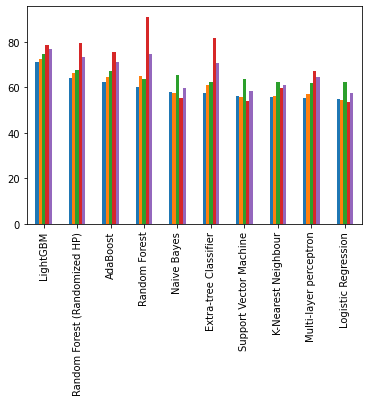

In [145]:
ax = model_score_df.plot.bar(legend=False)

### Saving Winner Model

In [146]:
pickle.dump(lgb_model, open('job_predict_model', 'wb'))

### Camparing Feature Importance

In [147]:
train_features.columns

Index(['salary', 'v1', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17',
       ...
       'jobtitle_keyword_senior', 'jobtitle_keyword_seo',
       'jobtitle_keyword_shop', 'jobtitle_keyword_software',
       'jobtitle_keyword_supplier', 'jobtitle_keyword_sustainability',
       'jobtitle_keyword_transformation', 'jobtitle_keyword_ui',
       'jobtitle_keyword_ux', 'jobtitle_keyword_ventures'],
      dtype='object', length=128)

In [148]:
importances = rf_model.feature_importances_

feature_imp = {
  "salary": 0,
  "user_features": 0,
  "company": 0,
  "job_title": 0
}

for i in range(len(importances)):
    if i == 0:
        feature_imp['salary'] = importances[i]
    if i>=1 and i<=56:
        feature_imp['user_features'] = feature_imp['user_features'] + importances[i]
    if i>=57 and i<=64:
        feature_imp['company'] = feature_imp['company'] + importances[i]
    if i>=65 and i<=127:
        feature_imp['job_title'] = feature_imp['job_title'] + importances[i]

In [149]:
feature_importance = sorted(feature_imp.items())
feature_importance.sort(key = lambda x: x[1], reverse = True)  
x, y = zip(* feature_importance)

feature_importance_df = pd.DataFrame({'features': x, 'importance': y}) 
for i, row in feature_importance_df.iterrows():
    rounded_value = round(feature_importance_df.at[i,'importance']*100,3)
    feature_importance_df.at[i,'importance'] = rounded_value

feature_importance_df.head()

,features,importance
0,user_features,89.715
1,job_title,6.261
2,salary,2.960
3,company,1.064
